# Multi Model GP

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import shutil

## Style sheet
plt.style.use("seaborn-v0_8-paper")
latex_installed = shutil.which("latex") is not None

rcparams = {
    "text.usetex": latex_installed,
    "font.size": 12,
    "lines.linewidth": 2,
    "mathtext.fontset": "cm", 
}

if latex_installed:
    rcparams["text.latex.preamble"] = r"\usepackage{amsmath}"
    rcparams["font.family"] = "cmu serif"
else:
    rcparams["font.family"] = "serif"

plt.rcParams.update(rcparams)

### Function and Measurement generation 

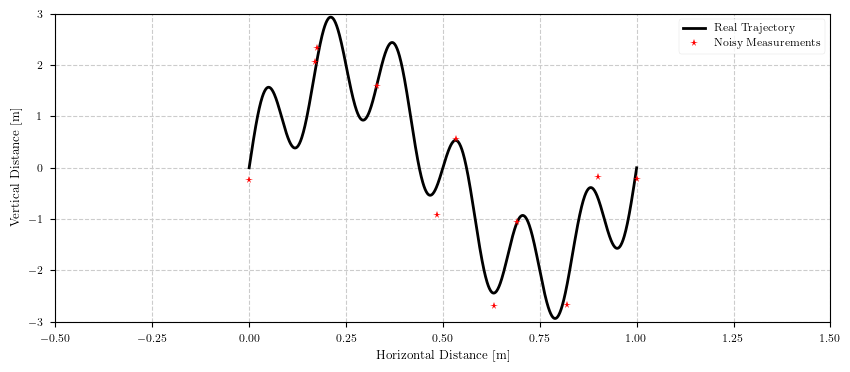

In [2]:
# Constants
np.random.seed(255)
dt = .001 # Length of each time step
num_steps = 1001  # Number of time steps for the simulation

# Observation noise
R = 0.05

# Generate the trajectory
timesteps = np.linspace(0, num_steps*dt, num_steps, endpoint=False)
underlying_function = np.sin(timesteps*6*2*np.pi) + 2*np.sin(timesteps*2*np.pi)

# Generate random measurements for each node
measurement_indices = [0] + list(np.random.choice(num_steps, 10)) + [num_steps-1]
num_meas = len(measurement_indices)
measurement_timesteps = np.array(timesteps[measurement_indices])
measurements = np.random.multivariate_normal(underlying_function[measurement_indices], R*np.eye(len(measurement_timesteps))).reshape((-1, 1))


# Visualization of the trajectory
fig, ax = plt.subplots()
fig.set_size_inches((10,4))
ax.grid(True,  linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)


xlims = [-.5, 1.5]
ylims = [-3, 3]
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("Horizontal Distance [m]")
ax.set_ylabel("Vertical Distance [m]")

ax.plot(timesteps, underlying_function, color='black', label="Real Trajectory")
ax.plot(measurement_timesteps, measurements, linestyle='', marker='*', color='red',  label='Noisy Measurements')

ax.legend()
plt.show()


### GP Parameters

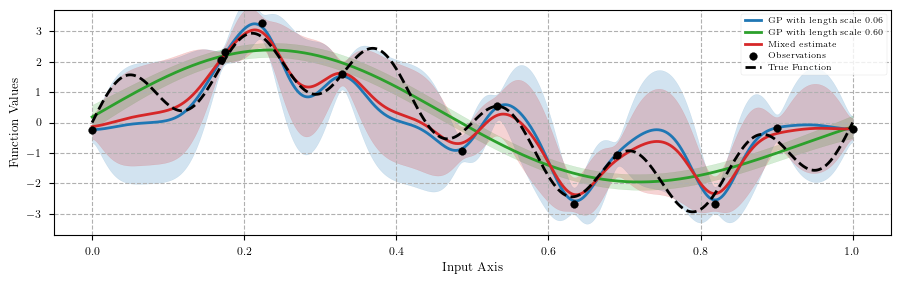

In [3]:
# Hyperparameters
length_scale = 0.25
sigma_prior = 1.0

def cholesky_inverse(A):
    try:
        A += 1e-9*np.eye(A.shape[0])
        L = np.linalg.cholesky(A)
        L_inv = np.linalg.inv(L)
        A_inv = L_inv.T @ L_inv
        return A_inv
    except np.linalg.LinAlgError:
        return "Error: Matrix is not positive definite or not symmetric."

# kernel function
def periodic_sq_exp_kernel(x1: np.ndarray, x2: np.ndarray, f: float = 1.0, ls=length_scale) -> np.ndarray:
    diff = x1.reshape((-1,1)) - x2.reshape((1,-1))
    return sigma_prior**2 * np.exp((-2/(length_scale**2))*(np.sin(f * np.abs(diff))**2))

def sq_exp_kernel(x1: np.ndarray, x2: np.ndarray, ls: float = length_scale) -> np.ndarray:
    diff = x1.reshape((-1,1)) - x2.reshape((1,-1))
    return sigma_prior**2 * np.exp((-2/(ls**2))*(np.abs(diff)**2))

# GP Priors
frequencies = np.array([0.06, 0.6])
num_frequencies = len(frequencies)
gp_covs = [sq_exp_kernel(measurement_timesteps, measurement_timesteps, frequencies[i]) + R*np.eye(num_meas)  for i in range(num_frequencies)]
inv_gp_covs = [cholesky_inverse(g) for g in gp_covs]
gp_cross_covs = [sq_exp_kernel(measurement_timesteps, timesteps, frequencies[i]) for i in range(num_frequencies)]
inv_pred_covs = [cholesky_inverse(sq_exp_kernel(timesteps, timesteps, frequencies[i])) for i in range(num_frequencies)]

# Inference
post_gp_means = [gp_cross_covs[i].T @ inv_gp_covs[i] @ measurements for i in range(num_frequencies)]
post_gp_covs = [sq_exp_kernel(timesteps, timesteps, frequencies[i]) - gp_cross_covs[i].T @ inv_gp_covs[i] @ gp_cross_covs[i] for i in range(num_frequencies)]

# Calculate likelihoods
measurement_likelihoods = [sp.stats.multivariate_normal.logpdf(measurements.flatten(), mean=np.zeros((num_meas,)).flatten(), cov=gp_covs[i]) for i in range(num_frequencies)]
measurement_likelihoods = 1/np.array(measurement_likelihoods) 
measurement_likelihoods = ((np.array(measurement_likelihoods))/np.sum(measurement_likelihoods))

mixed_post_mean = np.sum([measurement_likelihoods[i]*post_gp_means[i] for i in range(num_frequencies)], axis=0)
mixed_post_cov = np.sum([(measurement_likelihoods[i]**2)*(post_gp_covs[i] + (mixed_post_mean - post_gp_means[i])@(mixed_post_mean - post_gp_means[i]).T) for i in range(num_frequencies)], axis=0)

# Plotting
plt.figure(figsize=(12,3))
colors = ['tab:blue', 'tab:green', 'tab:orange']
labels = [f'GP with length scale {a:.2f}' for a in frequencies]

for i in range(num_frequencies):
    mean = post_gp_means[i].flatten()
    cov = post_gp_covs[i]
    std_dev = np.sqrt(np.diag(cov))

    # Plot GP mean
    plt.plot(timesteps, mean, color=colors[i], label=labels[i])

    # Plot confidence interval
    plt.fill_between(
        timesteps,
        mean - 2 * std_dev,
        mean + 2 * std_dev,
        color=colors[i],
        alpha=0.2
    )


# get mixed mean cov
mean = mixed_post_mean.flatten()
std_dev = np.sqrt(np.diag(mixed_post_cov))


# mixed mean
plt.plot(timesteps, mean, color="tab:red", label="Mixed estimate")

# mixed cov
plt.fill_between(
        timesteps,
        mean - 2 * std_dev,
        mean + 2 * std_dev,
        color="tab:red",
        alpha=0.2
)

# Plot measurements
plt.scatter(measurement_timesteps, measurements, color='black', zorder=5, label='Observations')

# Optionally plot ground truth if available
plt.plot(timesteps, underlying_function,'k--', label='True Function')


plt.xlabel('Input Axis')
plt.ylabel('Function Values')
plt.legend(fontsize=6)
plt.grid(True, ls="--")
plt.tight_layout()
plt.ylim([-3.7,3.7])
plt.gcf().gca().set_aspect(0.04)
plt.savefig("./figures/toy_scenario/estimates.pdf", format="pdf", bbox_inches="tight")
plt.show()


Component avg errors: [0.71513929 0.54020143]  Mixture avg error: 0.5273319535900516


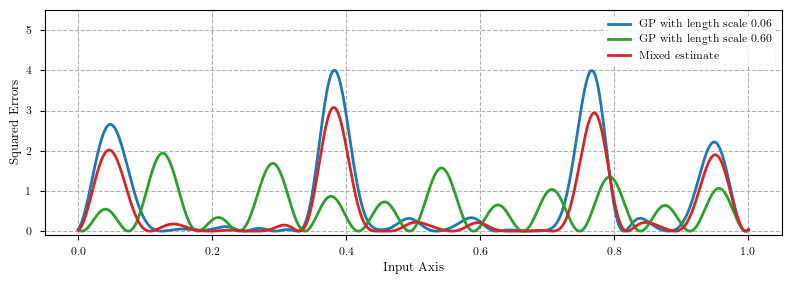

In [4]:
errors_components = [(post_gp_means[i].flatten() - underlying_function.flatten())**2 for i in range(num_frequencies)]
errors_mixture = (mixed_post_mean.flatten() - underlying_function.flatten())**2

# Plotting
plt.figure(figsize=(12, 3))
colors = ['tab:blue', 'tab:green', 'tab:orange']
labels = [f'GP with length scale {a:.2f}' for a in frequencies]

for i in range(num_frequencies):
    mean = errors_components[i].flatten()

    # Plot GP mean
    plt.plot(timesteps, mean, color=colors[i], label=labels[i])

mean_abs_errors = np.mean(errors_components, axis=1)
mean_mix_error = np.mean(errors_mixture)

print(f"Component avg errors: {mean_abs_errors}  Mixture avg error: {mean_mix_error}")

# get mixed mean cov
mean = errors_mixture.flatten()

# mixed mean
plt.plot(timesteps, mean, color="tab:red", label="Mixed estimate")


plt.xlabel('Input Axis')
plt.ylabel('Squared Errors')
plt.legend()
plt.grid(True, ls='--')
plt.tight_layout()
plt.ylim([-0.1,5.5])
plt.gcf().gca().set_aspect(0.06)
plt.savefig("./figures/toy_scenario/errors.pdf", format="pdf", bbox_inches="tight")
plt.show()

